# Support Vector Machines

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers
import seaborn as sns

sns.set_style("darkgrid")

In [4]:
mango = pd.read_excel('ML1_dataset.xlsx',sheet_name='Class 1 - Mango')
orange = pd.read_excel('ML1_dataset.xlsx',sheet_name='Class 2 - Orange')
banana = pd.read_excel('ML1_dataset.xlsx',sheet_name='Class 3 - Banana')

In [5]:
#create label for plotting
mango['Class'] = 'mango'
orange['Class'] = 'orange'
banana['Class'] = 'banana'

### Split data into train and test sets

In [6]:
def feature_class(class1,class2,num_train):
    class1['Label'] = 1
    class2['Label'] = -1
    
    feature_input = pd.concat([class1,class2],axis=0,ignore_index=True)
    skew_min, skew_max = feature_input['Skew'].min(), feature_input['Skew'].max()
    feature_input['Skew'] = (feature_input['Skew']-skew_min) / (skew_max-skew_min)
    feature_input['StDev'] = feature_input['StDev']/feature_input['StDev'].max()
    
    #create training set
    train_set_pd = feature_input.sample(num_train)
    train_expected = np.array(train_set_pd['Label']).reshape(-1,1)
    
    train_set = np.ones((num_train,4))
    train_set[:,1:] = train_set_pd[['Skew','StDev','Round']].to_numpy(dtype=float)
    
    #create test set
    if len(train_set_pd) != len(feature_input):
        test_set_pd = feature_input.drop(train_set_pd.index,axis=0)
        test_expected = np.array(test_set_pd['Label']).reshape(-1,1)

        test_set = np.ones((len(test_set_pd),4))
        test_set[:,1:] = test_set_pd[['Skew','StDev','Round']].to_numpy(dtype=float)
    else:
        test_set_pd = feature_input
        test_set = np.zeros((1,1))
        test_expected = np.zeros((1,1))
    
    return train_set, train_expected, test_set, test_expected, train_set_pd, test_set_pd

In [7]:
n = 30
train_set_mo,train_expected_mo,test_set_mo,test_expected_mo,train_pd_mo,test_pd_mo = feature_class(mango,orange,n)
train_set_mb,train_expected_mb,test_set_mb,test_expected_mb,train_pd_mb,test_pd_mb = feature_class(mango,banana,n)
train_set_bo,train_expected_bo,test_set_bo,test_expected_bo,train_pd_bo,test_pd_bo = feature_class(banana,orange,n)

print('Train dataset:',train_set_mo.shape)
print('Test dataset:',test_set_mo.shape)

Train dataset: (30, 4)
Test dataset: (12, 4)


### Solve for the eigenvalue and determine the weights

In [8]:
def eigenvalue(X,Z):
    
    n = X.shape[0]
    
    H = matrix(np.dot(Z,Z.T)*np.dot(X,X.T),tc='d')
    A = matrix(-np.identity(n),tc='d')
    B = matrix(Z,tc='d').T

    f = matrix(-np.ones((n,1)),tc='d')
    a = matrix(np.zeros((n,1)),tc='d')
    b = matrix(float(0))

    s = matrix(np.identity(n)*0.005,tc='d')
    
    sol = solvers.qp(H+s, f, A, a, B, b)
    
    return sol['x']

**Eigenvalue and weights for Training Set**

In [9]:
train_eigen_mo = eigenvalue(train_set_mo,train_expected_mo)
train_eigen_mb = eigenvalue(train_set_mb,train_expected_mb)
train_eigen_bo = eigenvalue(train_set_bo,train_expected_bo)

     pcost       dcost       gap    pres   dres
 0: -1.7098e+01 -4.5189e+01  3e+01  3e-16  2e+00
 1: -2.9884e+01 -4.3175e+01  1e+01  2e-15  1e+00
 2: -1.1701e+02 -1.4209e+02  3e+01  6e-15  1e+00
 3: -5.0530e+02 -6.0134e+02  1e+02  3e-14  9e-01
 4: -9.8263e+02 -1.2727e+03  3e+02  3e-13  4e-01
 5: -1.0523e+03 -1.0875e+03  4e+01  1e-13  4e-02
 6: -1.0530e+03 -1.0534e+03  4e-01  1e-13  4e-04
 7: -1.0530e+03 -1.0530e+03  4e-03  2e-13  4e-06
 8: -1.0530e+03 -1.0530e+03  4e-05  1e-13  4e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.6219e+01 -4.5795e+01  3e+01  4e-16  2e+00
 1: -2.8317e+01 -4.2028e+01  1e+01  1e-15  1e+00
 2: -1.0179e+02 -1.2546e+02  2e+01  1e-14  1e+00
 3: -4.1362e+02 -4.9551e+02  8e+01  3e-14  9e-01
 4: -9.5021e+02 -1.2885e+03  3e+02  1e-13  4e-01
 5: -9.8628e+02 -1.0156e+03  3e+01  6e-14  3e-02
 6: -9.8838e+02 -9.8928e+02  9e-01  1e-13  8e-04
 7: -9.8855e+02 -9.8856e+02  1e-02  2e-13  9e-06
 8: -9.8855e+02 -9.8855e+02  1e-04  1e-13  9e-0

In [10]:
train_W_mo = np.dot((train_eigen_mo * train_expected_mo).T,train_set_mo)
train_W_mb = np.dot((train_eigen_mb * train_expected_mb).T,train_set_mb)
train_W_bo = np.dot((train_eigen_bo * train_expected_bo).T,train_set_bo)

train_W0_mo = (1/train_expected_mo[0]) - np.dot(train_W_mo,train_set_mo[0].reshape(train_W_mo.shape[1],1))
train_W0_mb = (1/train_expected_mb[0]) - np.dot(train_W_mb,train_set_mb[0].reshape(train_W_mb.shape[1],1))
train_W0_bo = (1/train_expected_bo[0]) - np.dot(train_W_bo,train_set_bo[0].reshape(train_W_bo.shape[1],1))

**Eigenvalue and weights for Test Set**

In [11]:
test_eigen_mo = eigenvalue(test_set_mo,test_expected_mo)
test_eigen_mb = eigenvalue(test_set_mb,test_expected_mb)
test_eigen_bo = eigenvalue(test_set_bo,test_expected_bo)

     pcost       dcost       gap    pres   dres
 0: -6.2401e+00 -1.4830e+01  9e+00  4e-16  2e+00
 1: -1.0408e+01 -1.3384e+01  3e+00  8e-16  9e-01
 2: -2.9987e+01 -3.7645e+01  8e+00  3e-15  8e-01
 3: -4.3721e+01 -5.2778e+01  9e+00  3e-15  3e-01
 4: -4.6307e+01 -4.7101e+01  8e-01  6e-15  2e-02
 5: -4.6325e+01 -4.6339e+01  1e-02  9e-15  2e-04
 6: -4.6325e+01 -4.6326e+01  1e-04  1e-14  2e-06
 7: -4.6325e+01 -4.6325e+01  1e-06  1e-14  2e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -7.9703e+00 -1.9555e+01  1e+01  2e-16  2e+00
 1: -1.3495e+01 -1.7706e+01  4e+00  6e-16  1e+00
 2: -5.2975e+01 -6.7514e+01  1e+01  1e-14  9e-01
 3: -1.0003e+02 -1.2923e+02  3e+01  9e-15  7e-01
 4: -1.2743e+02 -1.4456e+02  2e+01  5e-14  2e-01
 5: -1.2931e+02 -1.2993e+02  6e-01  3e-14  5e-03
 6: -1.2932e+02 -1.2933e+02  8e-03  2e-14  6e-05
 7: -1.2932e+02 -1.2932e+02  8e-05  7e-15  6e-07
 8: -1.2932e+02 -1.2932e+02  8e-07  1e-14  6e-09
Optimal solution found.
     pcost       dcost 

In [12]:
test_W_mo = np.dot((test_eigen_mo * test_expected_mo).T,test_set_mo)
test_W_mb = np.dot((test_eigen_mb * test_expected_mb).T,test_set_mb)
test_W_bo = np.dot((test_eigen_bo * test_expected_bo).T,test_set_bo)

test_W0_mo = (1/test_expected_mo[0]) - np.dot(test_W_mo,test_set_mo[0].reshape(test_W_mo.shape[1],1))
test_W0_mb = (1/test_expected_mb[0]) - np.dot(test_W_mb,test_set_mb[0].reshape(test_W_mb.shape[1],1))
test_W0_bo = (1/test_expected_bo[0]) - np.dot(test_W_bo,test_set_bo[0].reshape(test_W_bo.shape[1],1))

### Plot 2-class Decision Boundary

In [13]:
def feature_input(class1,class2):
    feature_input = pd.concat([class1,class2],axis=0,ignore_index=True)
    skew_min, skew_max = feature_input['Skew'].min(), feature_input['Skew'].max()
    feature_input['Skew'] = (feature_input['Skew']-skew_min) / (skew_max-skew_min)
    feature_input['StDev'] = feature_input['StDev']/feature_input['StDev'].max()
    
    return feature_input

In [14]:
def plot_2class(data,W,W0,x,y,hue,savename):
    
    A, B, C = W[0,1], W[0,2], W0.flatten()
    y_bound = (C/B) - (A/B)*data[x]

    g = sns.scatterplot(data=data, x=x, y=y, hue=hue)    
    plt.plot(data[x],y_bound/max(y_bound))

    g.set_title('SVM 2-Class Decision Boundary')
    handles, labels = g.get_legend_handles_labels()
    g.legend(handles=handles[1:],labels=labels[1:],bbox_to_anchor=(1.28,1.0))
    plt.savefig(savename,bbox_inches='tight',dpi=300)
    plt.show()

**Plots for training set**

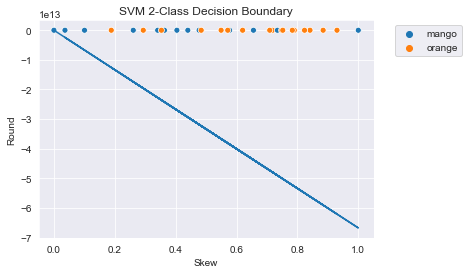

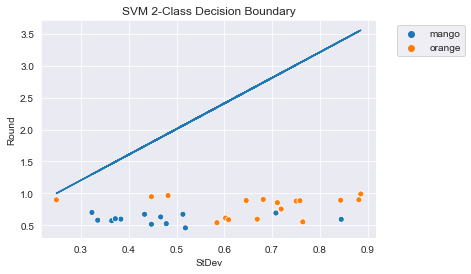

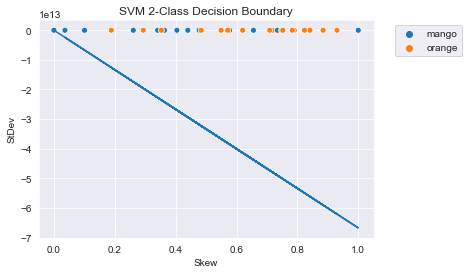

In [15]:
plot_2class(train_pd_mo,train_W_mo,train_W0_mo,'Skew','Round','Class','SVM_train_mo_skew_round.png')
plot_2class(train_pd_mo,train_W_mo,train_W0_mo,'StDev','Round','Class','SVM_train_mo_stdev_round.png')
plot_2class(train_pd_mo,train_W_mo,train_W0_mo,'Skew','StDev','Class','SVM_train_mo_skew_stdev.png')

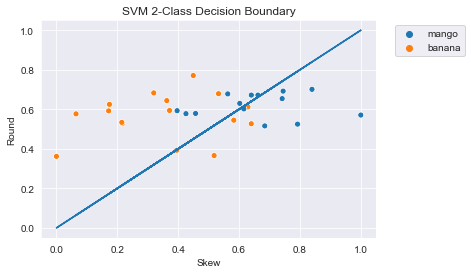

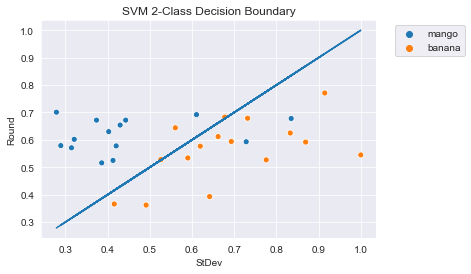

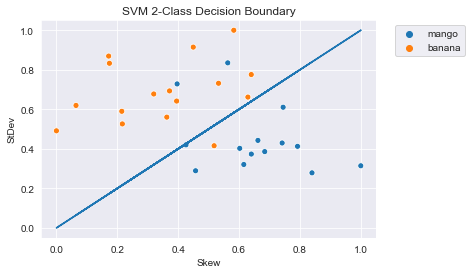

In [16]:
plot_2class(train_pd_mb,train_W_mb,train_W0_mb,'Skew','Round','Class','SVM_train_mb_skew_round.png')
plot_2class(train_pd_mb,train_W_mb,train_W0_mb,'StDev','Round','Class','SVM_train_mb_stdev_round.png')
plot_2class(train_pd_mb,train_W_mb,train_W0_mb,'Skew','StDev','Class','SVM_train_mb_skew_stdev.png')

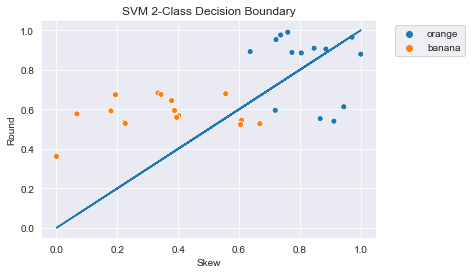

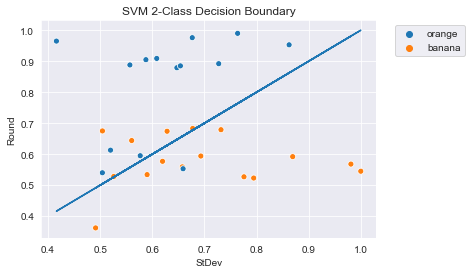

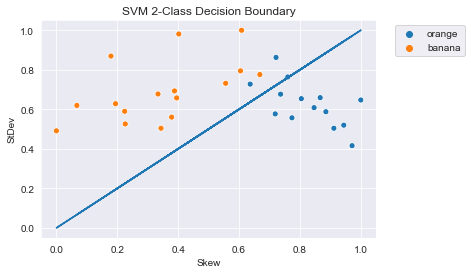

In [17]:
plot_2class(train_pd_bo,train_W_bo,train_W0_bo,'Skew','Round','Class','SVM_train_bo_skew_round.png')
plot_2class(train_pd_bo,train_W_bo,train_W0_bo,'StDev','Round','Class','SVM_train_bo_stdev_round.png')
plot_2class(train_pd_bo,train_W_bo,train_W0_bo,'Skew','StDev','Class','SVM_train_bo_skew_stdev.png')

**Plots for Test Set**

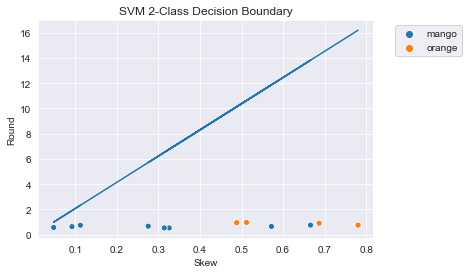

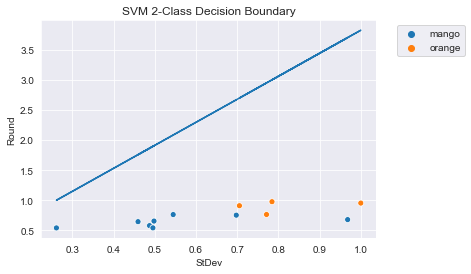

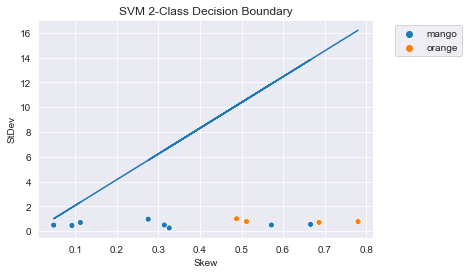

In [18]:
plot_2class(test_pd_mo,test_W_mo,test_W0_mo,'Skew','Round','Class','SVM_test_mo_skew_round.png')
plot_2class(test_pd_mo,test_W_mo,test_W0_mo,'StDev','Round','Class','SVM_test_mo_stdev_round.png')
plot_2class(test_pd_mo,test_W_mo,test_W0_mo,'Skew','StDev','Class','SVM_test_mo_skew_stdev.png')

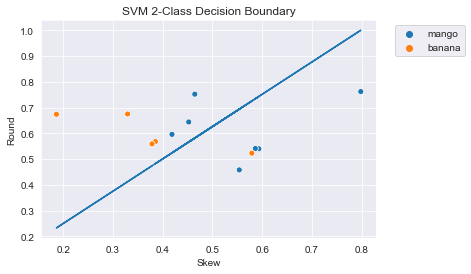

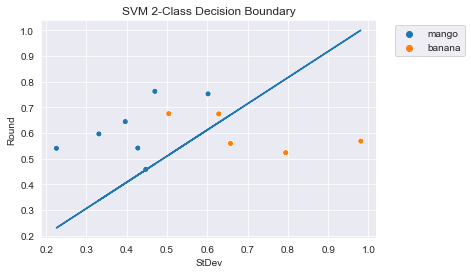

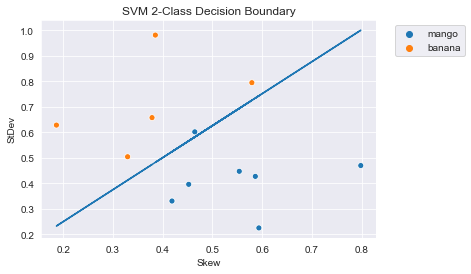

In [19]:
plot_2class(test_pd_mb,train_W_mb,test_W0_mb,'Skew','Round','Class','SVM_test_mb_skew_round.png')
plot_2class(test_pd_mb,train_W_mb,test_W0_mb,'StDev','Round','Class','SVM_test_mb_stdev_round.png')
plot_2class(test_pd_mb,train_W_mb,test_W0_mb,'Skew','StDev','Class','SVM_test_mb_skew_stdev.png')

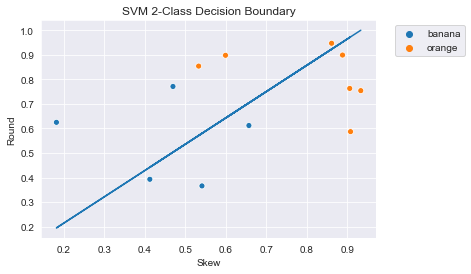

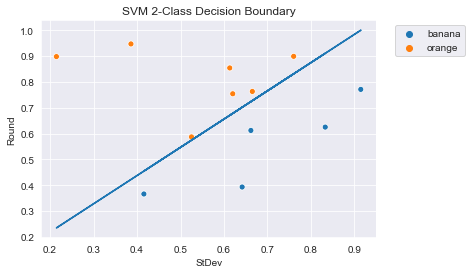

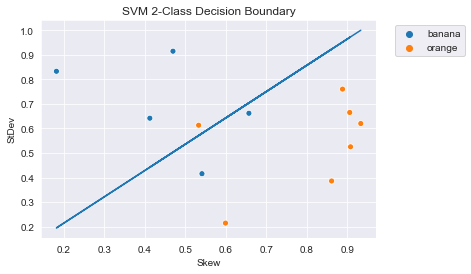

In [20]:
plot_2class(test_pd_bo,test_W_bo,test_W0_bo,'Skew','Round','Class','SVM_test_bo_skew_round.png')
plot_2class(test_pd_bo,test_W_bo,test_W0_bo,'StDev','Round','Class','SVM_test_bo_stdev_round.png')
plot_2class(test_pd_bo,test_W_bo,test_W0_bo,'Skew','StDev','Class','SVM_test_bo_skew_stdev.png')

### Training Accuracy of SVM Model

In [21]:
def accuracy(feature,W,W0,expected):
    
    z = W0 + np.dot(feature,W.T)    
    a = np.ones(shape=z.shape)
    a[np.where(z<0)] = -1
    
    training_output = pd.DataFrame([a.flatten(),expected.flatten()],index=['predicted','expected']).T
    true_pos = training_output[(training_output.predicted > 0) & (training_output.expected == 1)]
    true_neg = training_output[(training_output.predicted < 0) & (training_output.expected == -1)]
    correct = len(true_pos) + len(true_neg)
    accuracy = (correct/len(training_output))*100

    return accuracy

In [22]:
print("Mango-Orange Model Training Accuracy: {}".format(accuracy(train_set_mo,train_W_mo,train_W0_mo,train_expected_mo)))
print("Mango-Banana Model Training Accuracy: {}".format(accuracy(train_set_mb,train_W_mb,train_W0_mb,train_expected_mb)))
print("Banana-Orange Model Training Accuracy: {}".format(accuracy(train_set_bo,train_W_bo,train_W0_bo,train_expected_bo)))

Mango-Orange Model Training Accuracy: 83.33333333333334
Mango-Banana Model Training Accuracy: 83.33333333333334
Banana-Orange Model Training Accuracy: 83.33333333333334


In [23]:
print("Mango-Orange Model Training Accuracy: {}".format(accuracy(test_set_mo,test_W_mo,test_W0_mo,test_expected_mo)))
print("Mango-Banana Model Training Accuracy: {}".format(accuracy(test_set_mb,test_W_mb,test_W0_mb,test_expected_mb)))
print("Banana-Orange Model Training Accuracy: {}".format(accuracy(test_set_bo,test_W_bo,test_W0_bo,test_expected_bo)))

Mango-Orange Model Training Accuracy: 83.33333333333334
Mango-Banana Model Training Accuracy: 100.0
Banana-Orange Model Training Accuracy: 100.0
